Implementation of Fully Convolutional Networks for Image Segmantation (FCN) applied to VOCSegmentation dataset trained from scratch. 

Chosen model architecture was FCN-8 as presented in the paper below.

## [Paper](https://arxiv.org/abs/1411.4038)

## Imports

In [ ]:
import os
import time
import random

import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt 
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import functional as TF

# Fix random seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using {device}")

Using cuda:0


## Dataset

Download data from official site, define transforms and load images. Torchvision transforms are not applied to the target image, so we define them by hand as done in https://github.com/pytorch/vision/blob/master/references/segmentation/transforms.py



In [ ]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = TF.resize(image, self.size)
        target = TF.resize(target, self.size)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, flip_prob=0.5):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = TF.hflip(image)
            target = TF.hflip(target)
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = TF.to_tensor(image)
        
        target = np.array(target, dtype=np.float32)
        target = TF.to_tensor(target).long()

        return image, target.squeeze()


In [ ]:
train_augmentation = Compose(
    [
        RandomHorizontalFlip(),
        Resize((256, 256)),
        ToTensor(),
    ]
)

test_augmentation = Compose([Resize((256, 256)), ToTensor()])

train_data = VOCSegmentation(
    "sample_data", download=True, transforms=train_augmentation
)
test_data = VOCSegmentation(
    "sample_data", image_set="val", download=True, transforms=test_augmentation
)


Using downloaded and verified file: sample_data/VOCtrainval_11-May-2012.tar
Extracting sample_data/VOCtrainval_11-May-2012.tar to sample_data
Using downloaded and verified file: sample_data/VOCtrainval_11-May-2012.tar
Extracting sample_data/VOCtrainval_11-May-2012.tar to sample_data


## Model

In [ ]:
class FCN8Model(nn.Module):
    def __init__(self, n_classes, pretrained=True):
        super(FCN8Model, self).__init__()
        vgg_layers = torchvision.models.vgg16(pretrained=pretrained).features

        self.backbone = vgg_layers[0:10]
        self.pool3 = vgg_layers[10:17]
        self.pool4 = vgg_layers[17:24]
        self.pool5 = vgg_layers[24:]

        self.up1 = nn.ConvTranspose2d(
            in_channels=512, out_channels=512, kernel_size=2, stride=2
        )
        self.up2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=2, stride=2
        )

        self.prediction = nn.ConvTranspose2d(
            in_channels=256, out_channels=n_classes, kernel_size=8, stride=8
        )

    def forward(self, x):
        # Downsampling
        features = self.backbone(x)
        pool3 = self.pool3(features)
        pool4 = self.pool4(pool3)
        pool5 = self.pool5(pool4)

        # Upsampling and skip connections
        up_pool5 = self.up1(pool5)
        up_features = self.up2(up_pool5 + pool4)
        predictions = self.prediction(up_features + pool3)

        return predictions


## Training

In [ ]:
def pixel_accuracy(preds, label):
    probs = torch.log_softmax(preds, dim=1)
    predictions = torch.argmax(probs, dim=1)
    corrects = (predictions == label).float()
    acc = corrects.sum() / corrects.numel()

    return acc.cpu()


In [ ]:
def train_epoch(
    model,
    optimizer,
    dataloader,
    loss,
):
    model.train()
    epoch_loss = 0
    all_accuracies = []

    for input_images, targets in dataloader:
      optimizer.zero_grad()
      targets = targets.to(device)

      predictions = model(input_images.to(device))
      
      all_accuracies.append(pixel_accuracy(predictions, targets))

      cost = loss(predictions, targets)
      epoch_loss += cost.item()

      cost.backward()
      optimizer.step()
    
    return epoch_loss / len(dataloader), np.mean(all_accuracies)

def test_epoch(
    model,
    optimizer,
    dataloader,
    loss,
):
    model.eval()
    epoch_loss = 0
    all_accuracies = []

    with torch.no_grad():
      for input_images, targets in dataloader:
        predictions = model(input_images.to(device))
        targets = targets.to(device)

        cost = loss(predictions, targets)
        epoch_loss += cost.item()

        all_accuracies.append(pixel_accuracy(predictions, targets))

    return epoch_loss / len(dataloader), np.mean(all_accuracies)


In [ ]:
def segmentation_train(
    model,
    optimizer,
    lr_scheduler,
    train_dataloader,
    val_dataloader,
    epochs=50,
):
    train_loss_hist = []
    train_acc_hist = []
    val_loss_hist = []
    val_acc_hist = []

    best_model_weights = None
    best_val_acc = 0

    loss_function = nn.CrossEntropyLoss(ignore_index=255).to(device)

    for epoch in range(epochs):
        start = time.time()
        train_loss, train_acc = train_epoch(
            model, optimizer, train_dataloader, loss_function
        )
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)

        val_loss, val_acc = test_epoch(
            model, optimizer, train_dataloader, loss_function
        )
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)

        if val_acc > best_val_acc:
          best_val_acc = val_acc
          best_model_weights = model.state_dict().copy()

        lr_scheduler.step()

        print(
            f"Epoch {epoch + 1} | "
            f"Train Loss {train_loss:.6f} | "
            f"Train pixel accuracy {train_acc:.2f} | "
            f"Val Loss {val_loss:.6f} | "
            f"Validation pixel accuracy {val_acc:.2f} | "
            f"Time {time.time() - start:.2f} sec"
        )
    
    model.load_state_dict(best_model_weights)

    return (
        train_loss_hist,
        val_loss_hist,
        train_acc_hist,
        val_acc_hist,
    )


## Results

In [ ]:
PASCAL_VOC_CLASSES = len(VOC_CLASSES)

train_dataloader = DataLoader(
    train_data, batch_size=32, num_workers=2, pin_memory=True
)
val_dataloader = DataLoader(test_data, batch_size=32, num_workers=2, pin_memory=True)

# Define model
fcn_model = FCN8Model(n_classes=PASCAL_VOC_CLASSES, pretrained=True).to(device)

net_optimizer = torch.optim.Adam(fcn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(net_optimizer, step_size=100)


In [ ]:
N_EPOCHS = 130

train_losses, val_losses, train_acc, val_acc = segmentation_train(
    fcn_model, net_optimizer, scheduler, train_dataloader, val_dataloader, epochs=N_EPOCHS
)


Epoch 1 | Train Loss 1.646132 | Train pixel accuracy 0.63 | Val Loss 1.198467 | Validation pixel accuracy 0.69 | Time 62.76 sec
Epoch 2 | Train Loss 1.196066 | Train pixel accuracy 0.69 | Val Loss 1.161230 | Validation pixel accuracy 0.69 | Time 61.33 sec
Epoch 3 | Train Loss 1.136176 | Train pixel accuracy 0.69 | Val Loss 1.084888 | Validation pixel accuracy 0.70 | Time 62.17 sec
Epoch 4 | Train Loss 1.061237 | Train pixel accuracy 0.70 | Val Loss 1.008322 | Validation pixel accuracy 0.70 | Time 62.84 sec
Epoch 5 | Train Loss 1.022093 | Train pixel accuracy 0.70 | Val Loss 0.972845 | Validation pixel accuracy 0.71 | Time 63.27 sec
Epoch 6 | Train Loss 1.002383 | Train pixel accuracy 0.71 | Val Loss 0.954535 | Validation pixel accuracy 0.71 | Time 63.31 sec
Epoch 7 | Train Loss 0.959097 | Train pixel accuracy 0.71 | Val Loss 0.966926 | Validation pixel accuracy 0.70 | Time 63.61 sec
Epoch 8 | Train Loss 0.932819 | Train pixel accuracy 0.71 | Val Loss 0.887139 | Validation pixel accurac

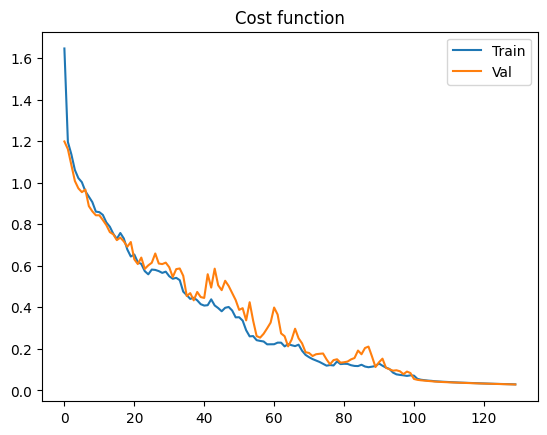

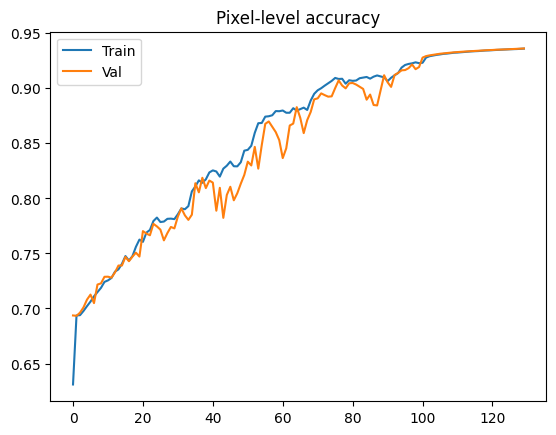

In [ ]:
plt.plot(range(N_EPOCHS), train_losses, label="Train")
plt.plot(range(N_EPOCHS), val_losses, label="Val")
plt.legend()
plt.title("Cost function")
plt.show()

plt.plot(range(N_EPOCHS), train_acc, label="Train") 
plt.plot(range(N_EPOCHS), val_acc, label="Val")
plt.legend()
plt.title("Pixel-level accuracy")
plt.show()


### Visualizations

In [ ]:
def mask_to_image(mask):
  VOC_COLORMAP
  image = np.zeros((256, 256, 3))
  for class_idx, colour in enumerate(VOC_COLORMAP):
    image[mask == class_idx, :] = colour

  return image.astype(np.uint8)

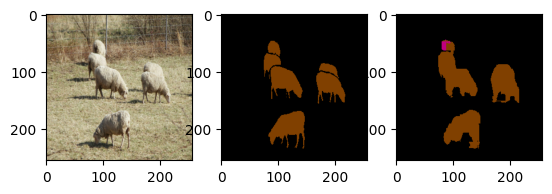

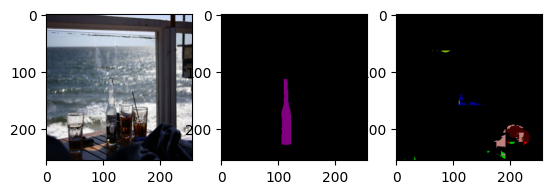

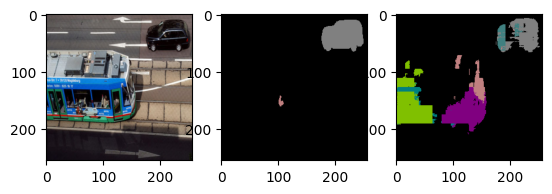

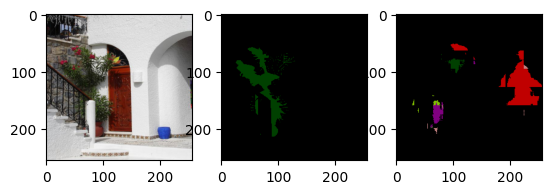

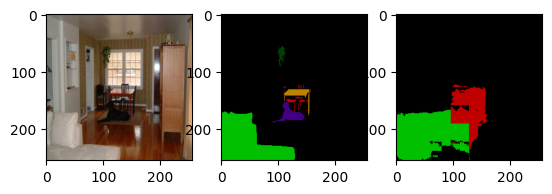

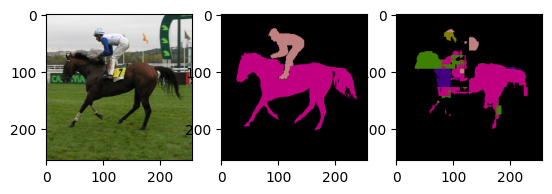

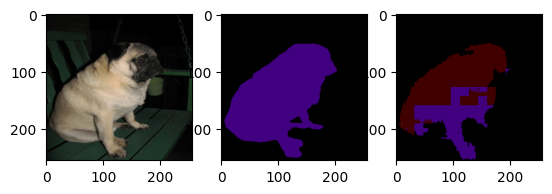

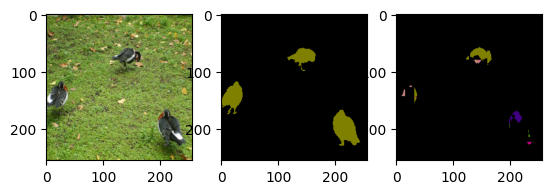

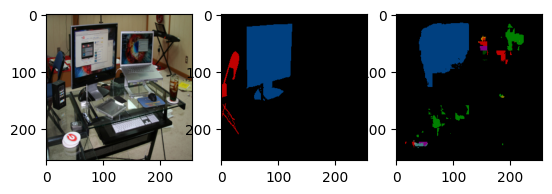

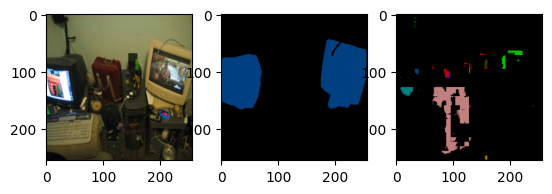

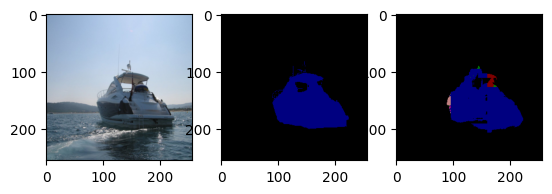

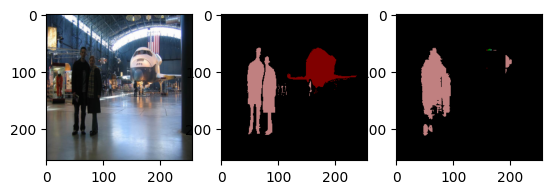

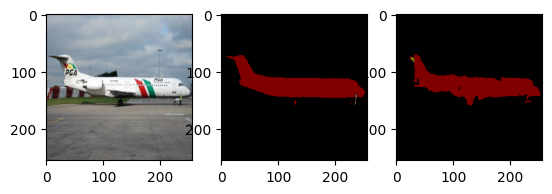

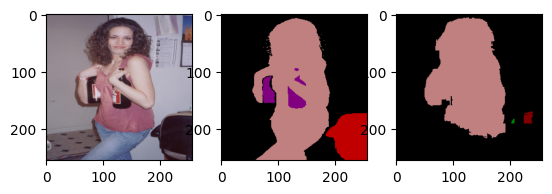

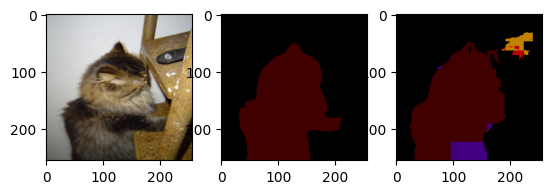

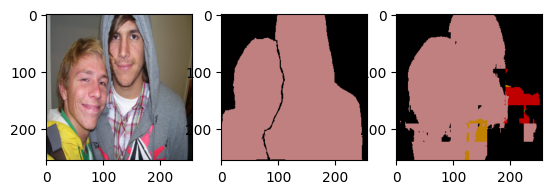

In [ ]:
vis_dataloader = DataLoader(test_data, batch_size=16, num_workers=2, shuffle=True)
vis_batch, targets = next(iter(vis_dataloader))

predictions = torch.softmax(fcn_model(vis_batch.to(device)), dim=1)
predictions = torch.argmax(predictions, dim=1)


for idx, image in enumerate(vis_batch):
  fig, axes = plt.subplots(nrows=1, ncols=3)
  axes[0].imshow(image.cpu().numpy().transpose(1, 2, 0))
  axes[1].imshow(mask_to_image(targets[idx]))
  axes[2].imshow(mask_to_image(predictions[idx].cpu()))
